# Предисловие 

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

__Необходимо разработать модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59.__

# Импорт библиотек

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from itertools import product
from sklearn.metrics import f1_score,roc_auc_score,precision_score,recall_score, precision_recall_curve,roc_curve,accuracy_score
from tqdm.notebook import trange, tqdm
import warnings
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
import numpy as np

# Функции

In [4]:
def curve(recall,precision,variant):
    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Кривая Precision-Recall {variant}')
    plt.show() 

In [5]:
def roc_curve_plot(fpr,tpr,variant):
    plt.figure()
    plt.figure(figsize=(6, 6))
    plt.step(fpr, tpr, where='post')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'ROC-кривая {variant}')
    plt.show() 

In [6]:
def both_pr_curve(recall,precision,recall_test,precision_test, variant):
    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.step(recall_test, precision_test, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Кривая Precision-Recall для валидационной и тестовой выборки {variant}')
    plt.legend(['valid','test'])
    plt.show() 

In [7]:
def both_roc_auc_curve(fpr,tpr,fpr_test,tpr_test, variant):
    plt.figure()
    plt.figure(figsize=(6, 6))
    plt.step(fpr, tpr, where='post')
    plt.step(fpr_test, tpr_test, where='post')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'ROC-кривая валидационной и тестовой выборки {variant}')
    plt.legend(['valid','test'])
    plt.show() 

In [8]:
def upsample(features,target,repeat):
    features_zeros = features.loc[target==0]
    features_ones = features.loc[target==1]
    target_zeros = target.loc[target==0]
    target_ones = target.loc[target==1]
    
    features_upsampled = pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros]+[target_ones]*repeat)
    
    return features_upsampled,target_upsampled

In [9]:
def downsample(features,target,fraction):
    
    features_zeros = features.loc[target==0]
    features_ones = features.loc[target==1]
    target_zeros = target.loc[target==0]
    target_ones = target.loc[target==1]
    
    features_sample = features_zeros.sample(frac=fraction, random_state = 12345)
    target_sample = target_zeros.sample(frac=fraction, random_state = 12345)
    
    features_downsampled = pd.concat([features_sample]+[features_ones])
    target_downsampled = pd.concat([target_sample]+[target_ones])
    
    return features_downsampled,target_downsampled

In [10]:
def random_forest_learning(feauters_train, target_train, feauters_valid,target_valid,max_depth, class_weight = None):
    best_model = None
    best_result = 0
    df_random_forest = pd.DataFrame(columns = ['максимальная глубина','f1'])
    for depth in tqdm(range(1,max_depth,1)):
        for est in range(1,101,10):
            model = RandomForestClassifier(random_state = 1234,max_depth = depth,class_weight = class_weight,n_estimators=est)
            model.fit(feauters_train, target_train)
            predictions = model.predict(feauters_valid)  
            probabilities = model.predict_proba(feauters_valid)   
            probabilities_one_valid = probabilities[:,1]
            f1 = f1_score(target_valid,predictions)

            df_conc = pd.DataFrame({'максимальная глубина':[depth],
                                    'количество деревьев':[est],
                                     'f1': [f1]
                                   })
            df_random_forest= pd.concat([df_random_forest,df_conc])
            if f1>best_result:
                best_result=f1
                best_model = model
    
    return best_model,df_random_forest
    

In [11]:
def decision_tree_learning(feauters_train, target_train, feauters_valid,target_valid,max_depth, class_weight = None):
    best_model = None
    best_result = 0
    df_decision_tree = pd.DataFrame(columns = ['максимальная глубина','f1'])
    for depth in tqdm(range(1,max_depth,1)):
        model = DecisionTreeClassifier(random_state = 1234,max_depth = depth,class_weight = class_weight)
        model.fit(feauters_train, target_train)
        predictions = model.predict(feauters_valid)  
        probabilities = model.predict_proba(feauters_valid)   
        probabilities_one_valid = probabilities[:,1]
        f1 = f1_score(target_valid,predictions)

        df_conc = pd.DataFrame({'максимальная глубина':[depth],
                                 'f1': [f1]
                               })
        df_decision_tree= pd.concat([df_decision_tree,df_conc])
        if f1>best_result:
            best_result=f1
            best_model = model
    
    return best_model,df_decision_tree

# Обработка данных

In [12]:
data = pd.read_csv('Churn.csv')

In [13]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


__Признаки__
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

__Целевой признак__
- Exited — факт ухода клиента

__Вывод:__ так, как необходимо предсказать уход клиента, то будем решать задачу классификации. 

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим пропуски в столбце "Tenure"

In [15]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [16]:
data.loc[data['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


В данном контексте, пропуски не были проставлены намерено. 

In [17]:
data.drop(columns = ['Surname','CustomerId','Geography','Gender','RowNumber']).corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Tenure ни с чем не коррелирует, заполним средним значением. 

In [18]:
round(data.Tenure.mean(),2)

5.0

In [19]:
data.loc[data['Tenure'].isna(), 'Tenure'] = round(data.Tenure.mean(),2)

In [20]:
data.Tenure.isna().sum()

0

In [21]:
data.columns = data.columns.str.lower()

In [22]:
data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


# Подготовка данных перед обучением

## Необходимо удалить признаки, которые не имеют предсказательной силы и могут запутать модель. 

In [23]:
data_new = data.drop(columns = ['rownumber','customerid','surname'])

In [24]:
data_new

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


## Разделим выборку на тренировочную, тестовую и валидационную 

In [25]:
data_new = pd.get_dummies(data_new, drop_first = True,dtype=int)

In [26]:
feauters = data_new.drop(columns = 'exited', axis = 1)

In [27]:
target = data_new['exited']

In [28]:
feauters.shape

(10000, 11)

In [29]:
target.shape

(10000,)

In [30]:
feauters_valid_train, feauters_test, target_valid_train, target_test = train_test_split(feauters, target, test_size = 0.2, random_state = 12345)

In [31]:
feauters_train, feauters_valid, target_train, target_valid = train_test_split(feauters_valid_train, target_valid_train, test_size = 0.25, random_state = 12345)

In [32]:
print(feauters_test.shape)
print(target_test.shape)
print(feauters_valid.shape)
print(target_valid.shape)
print(feauters_train.shape)
print(target_train.shape)

(2000, 11)
(2000,)
(2000, 11)
(2000,)
(6000, 11)
(6000,)


## Стандартизируем количественные значения

In [33]:
scaler = StandardScaler()

In [34]:
numeric = ['creditscore','age','tenure','balance','estimatedsalary']

In [35]:
scaler.fit(feauters_train[numeric])

StandardScaler()

In [36]:
feauters_train[numeric] = scaler.transform(feauters_train[numeric])
feauters_valid[numeric] = scaler.transform(feauters_valid[numeric])
feauters_test[numeric] = scaler.transform(feauters_test[numeric])

# Исследуем баланс классов

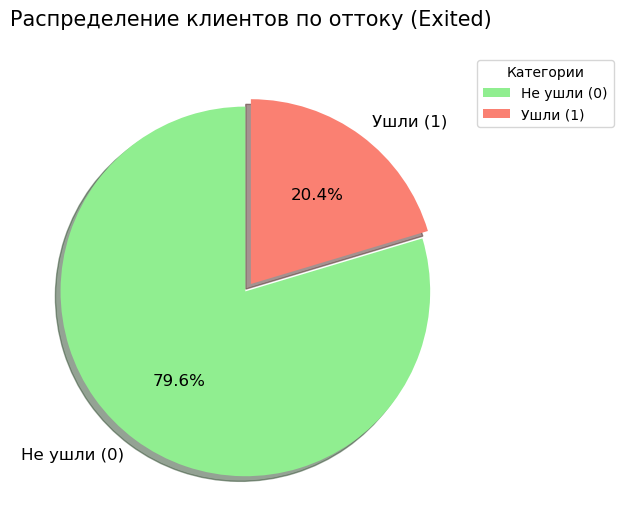

In [37]:
counts = data_new.exited.value_counts()


plt.figure(figsize=(8, 6))


patches, texts, autotexts = plt.pie(
    counts,
    labels=['Не ушли (0)', 'Ушли (1)'],  
    autopct='%1.1f%%',                   
    startangle=90,                       
    shadow=True,                          
    colors=['lightgreen', 'salmon'],     
    explode=(0.05, 0),                
    textprops={'fontsize': 12}        
)


plt.title('Распределение клиентов по оттоку (Exited)', fontsize=15, pad=20)


plt.legend(
    title='Категории',
    loc='upper right',
    bbox_to_anchor=(1.3, 1)
)


for autotext in autotexts:
    autotext.set_fontsize(12)


plt.show()

__Вывод:__ дисбаланс классов присутствует и он достаточно большой

# Прогноз без учета дисбаланса классов

## Модель логистической регрессии

In [38]:
model = LogisticRegression(random_state = 1234)

In [39]:
model.fit(feauters_train,target_train)

LogisticRegression(random_state=1234)

In [40]:
predictions = model.predict(feauters_valid)
probabilities = model.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]

In [41]:
f1 = f1_score(target_valid,predictions)
print(f'F1 мера равна {f1}')

F1 мера равна 0.30131826741996237


In [42]:
max(probabilities_one_valid)

0.914159592932299

In [43]:
df_lin = pd.DataFrame(columns = ['порог','f1','полнота','точность'])

In [44]:
for treshhold in np.arange(0,0.92,0.05):
    predictions = (probabilities_one_valid>=treshhold).astype(int)
    
    df_conc = pd.DataFrame({'порог':[treshhold],
    'f1':f1_score(target_valid,predictions),
     'полнота':recall_score(target_valid,predictions),
     'точность':precision_score(target_valid,predictions)})
    
    df_lin= pd.concat([df_lin,df_conc])

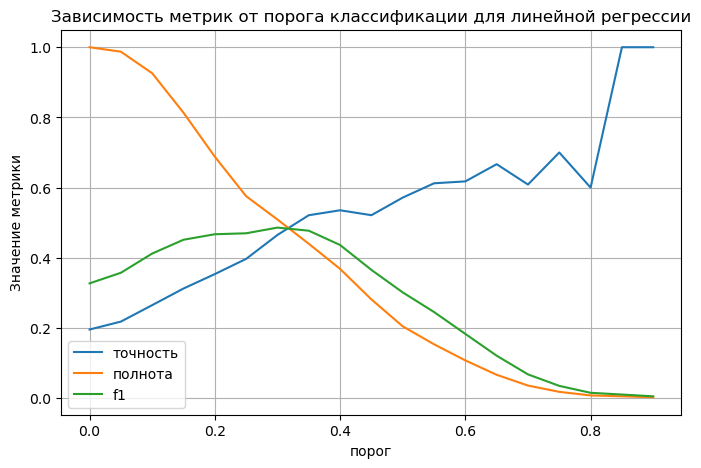

In [45]:

df_lin.plot(x='порог', y=['точность','полнота','f1'], grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрик от порога классификации для линейной регрессии');

Можно повысить f1 до 0.5 меняя значения трешхолда(границы вероятности). F1 максимальна при пороге 0.3 

Построим график ROC_AUC

In [46]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

<Figure size 640x480 with 0 Axes>

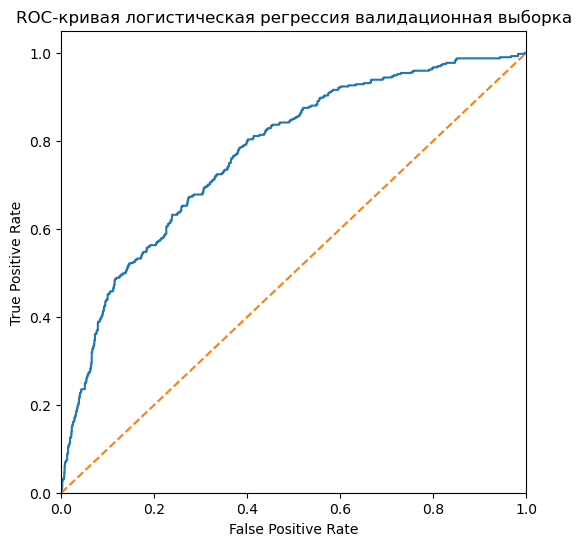

In [47]:
roc_curve_plot(fpr,tpr,variant = 'логистическая регрессия валидационная выборка')

In [48]:
roc_auc_score(target_valid, probabilities_one_valid)

0.7703343882476924

Модель предсказывает лучше случайной.

## Случайный лес

In [49]:
random_model,df_random_forest = random_forest_learning(feauters_train, target_train, feauters_valid,target_valid,max_depth =20 )

  0%|          | 0/19 [00:00<?, ?it/s]

In [50]:
random_model

RandomForestClassifier(max_depth=17, n_estimators=21, random_state=1234)

In [51]:
df_random_forest.f1.max()

0.5816485225505444

In [52]:
df_random_forest.sort_values(by = 'f1', ascending = False)

,максимальная глубина,f1,количество деревьев
0,17,0.581649,21.0
0,14,0.577223,11.0
0,17,0.574568,31.0
0,15,0.570973,41.0
0,14,0.570513,41.0
...,...,...,...
0,1,0.000000,91.0
0,1,0.000000,31.0
0,1,0.000000,41.0
0,1,0.000000,71.0


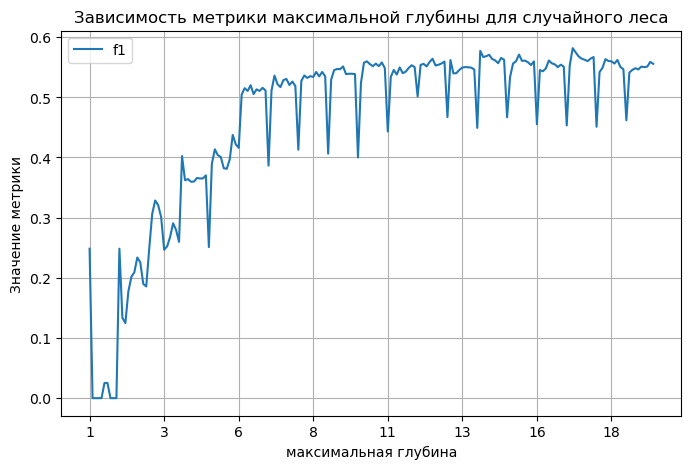

In [53]:
df_random_forest.plot(x='максимальная глубина', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики максимальной глубины для случайного леса');

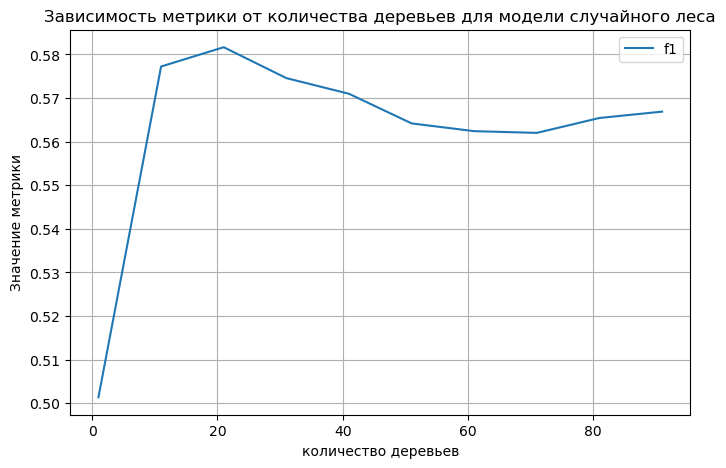

In [54]:
df_random_forest[['f1','количество деревьев']].drop_duplicates().query('f1>0').\
                        groupby('количество деревьев').agg({'f1':'max'}).reset_index().plot(x='количество деревьев', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики от количества деревьев для модели случайного леса');

Максимальное значение метрики f1 достигается при глубине дерева 17. Примерно 0.582 с количеством деревьев 21

Построим кривую ROC_AUC

<Figure size 640x480 with 0 Axes>

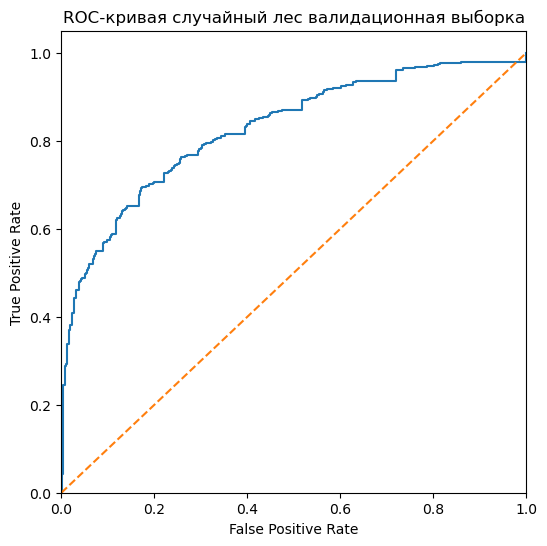

In [55]:
probabilities = random_model.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_curve_plot(fpr,tpr,variant = 'случайный лес валидационная выборка')

In [56]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8314341165979727

Левый верхний угол графика поднимается в верх, что означает что модель дает хорошие прогнозы, лучше чем у линейной регресии. Площадь под кривой близка к 0.83

## Решающее дерево

In [57]:
decision_tree_model,df_decision_tree = decision_tree_learning(feauters_train, target_train, feauters_valid,target_valid,max_depth =20 )

  0%|          | 0/19 [00:00<?, ?it/s]

In [58]:
decision_tree_model

DecisionTreeClassifier(max_depth=7, random_state=1234)

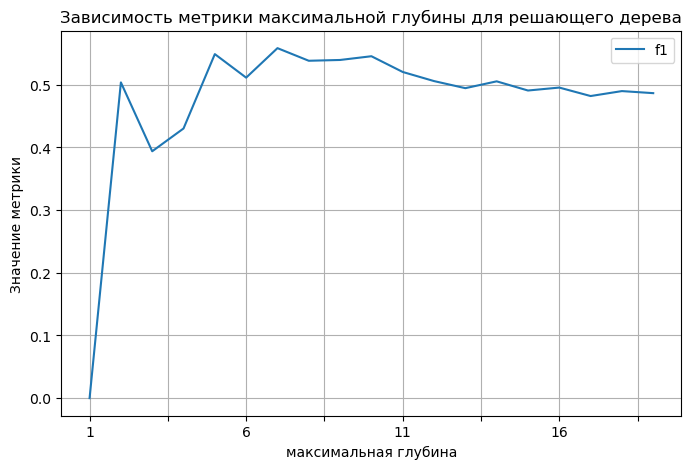

In [59]:
df_decision_tree.plot(x='максимальная глубина', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики максимальной глубины для решающего дерева');

Построим ROC_AUC для решающего дерева

<Figure size 640x480 with 0 Axes>

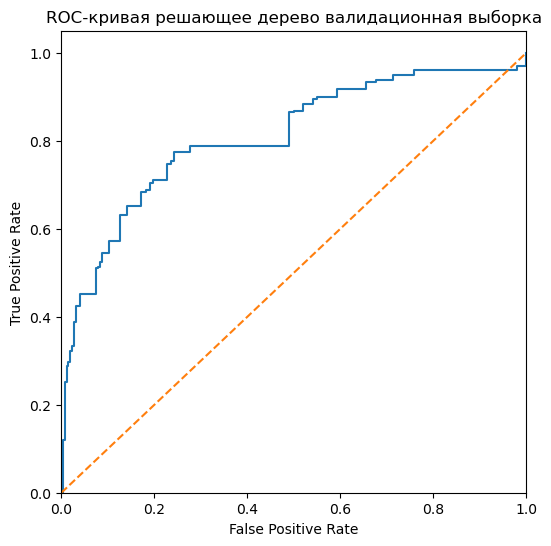

In [60]:
probabilities = decision_tree_model.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_curve_plot(fpr,tpr,variant = 'решающее дерево валидационная выборка')

In [61]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8231010349393358

Модель делает прогнозы чуть лучше логистической модели. Оптимальное количество глубины дерева для данной модели - 7. Можно достичь f1 - 0.55

# Прогноз с учетом дисбаланса классов 

## Модель логистической регрессии

In [62]:
model_lin = LogisticRegression(random_state = 1234, class_weight = 'balanced',solver = 'liblinear')

In [63]:
model_lin.fit(feauters_train,target_train)

LogisticRegression(class_weight='balanced', random_state=1234,
                   solver='liblinear')

In [64]:
predictions = model_lin.predict(feauters_valid)
probabilities = model_lin.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]

In [65]:
f1 = f1_score(target_valid,predictions)
print(f'F1 мера равна {f1}')

F1 мера равна 0.4741532976827095


In [66]:
max(probabilities_one_valid)

0.9794522863281094

In [67]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

<Figure size 640x480 with 0 Axes>

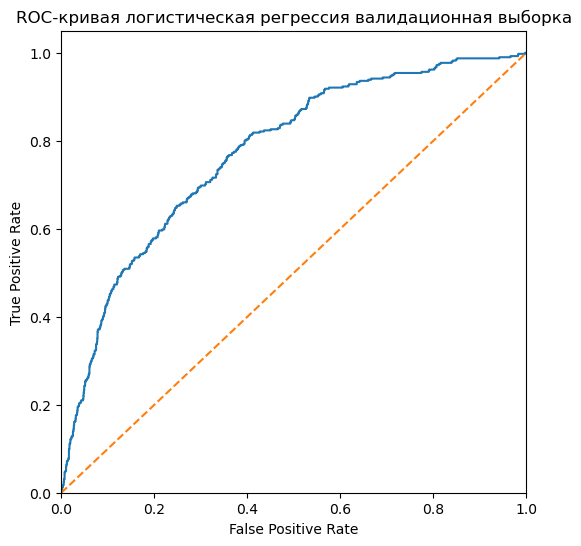

In [68]:
roc_curve_plot(fpr,tpr,variant = 'логистическая регрессия валидационная выборка')

In [69]:
roc_auc_score(target_valid, probabilities_one_valid)

0.7725581328810607

Эффект от применения баланса классов примерно такой же, как от сдига трешхола для вероятности класса 1

## Случайный лес

In [70]:
random_model_weighted,df_random_forest = random_forest_learning(feauters_train, target_train, feauters_valid,target_valid,max_depth =20, class_weight = 'balanced')

  0%|          | 0/19 [00:00<?, ?it/s]

In [71]:
random_model_weighted

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=31,
                       random_state=1234)

In [72]:
df_random_forest.sort_values(by = 'f1', ascending = False)

,максимальная глубина,f1,количество деревьев
0,12,0.598106,31.0
0,10,0.597990,61.0
0,11,0.597884,51.0
0,13,0.596491,81.0
0,12,0.596154,41.0
...,...,...,...
0,4,0.403283,1.0
0,3,0.401417,1.0
0,5,0.380658,1.0
0,2,0.344538,1.0


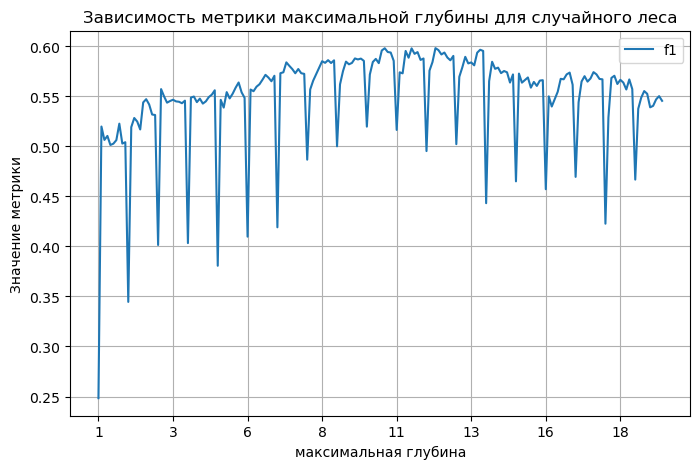

In [73]:
df_random_forest.plot(x='максимальная глубина', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики максимальной глубины для случайного леса');

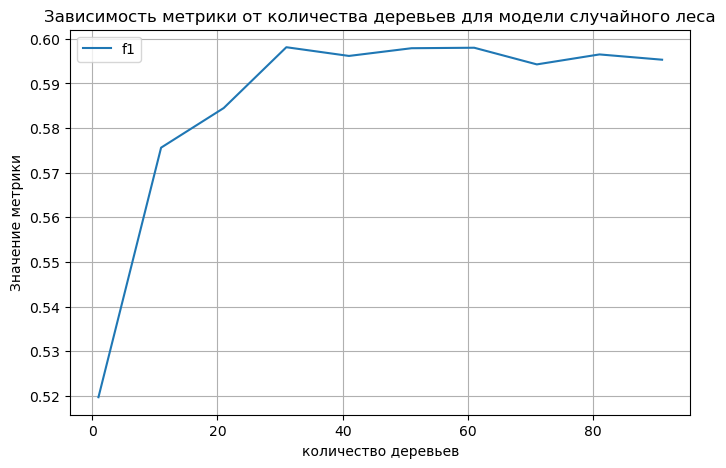

In [74]:
df_random_forest[['f1','количество деревьев']].drop_duplicates().query('f1>0').\
                        groupby('количество деревьев').agg({'f1':'max'}).reset_index().plot(x='количество деревьев', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики от количества деревьев для модели случайного леса');

<Figure size 640x480 with 0 Axes>

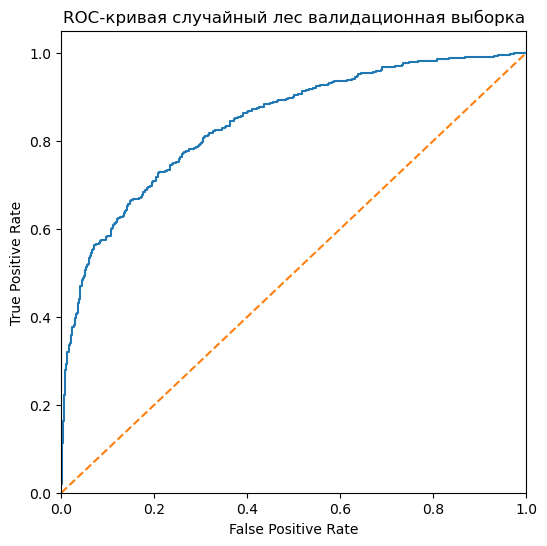

In [75]:
probabilities = random_model_weighted.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_curve_plot(fpr,tpr,variant = 'случайный лес валидационная выборка')

In [76]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8407288605176447

При балансе классов достигаем метрики f1 примерно равной 0.6 с максимальной глубиной дерева 12 и количеством деревьев 31. Площадь под кривой ROC_AUC так же увеличивается.

## Решающее дерево

In [77]:
decision_tree_model_weighted,df_decision_tree = decision_tree_learning(feauters_train, target_train, \
                                                                       feauters_valid,target_valid,max_depth =20, class_weight = 'balanced' )

  0%|          | 0/19 [00:00<?, ?it/s]

In [78]:
decision_tree_model_weighted

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=1234)

In [79]:
df_decision_tree.f1.max()

0.5587044534412956

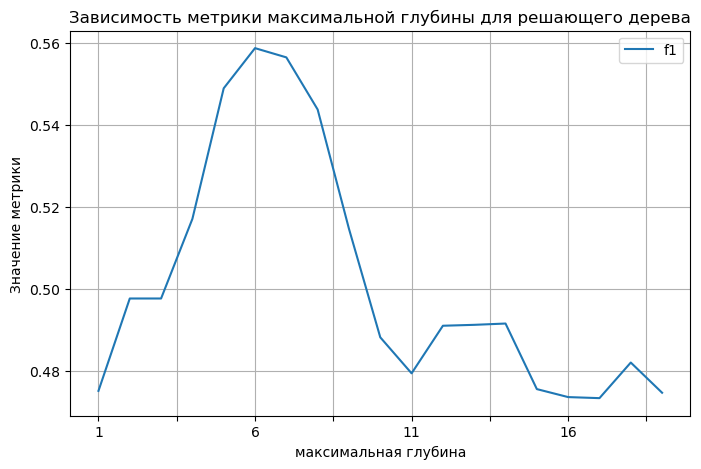

In [80]:
df_decision_tree.plot(x='максимальная глубина', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики максимальной глубины для решающего дерева');

<Figure size 640x480 with 0 Axes>

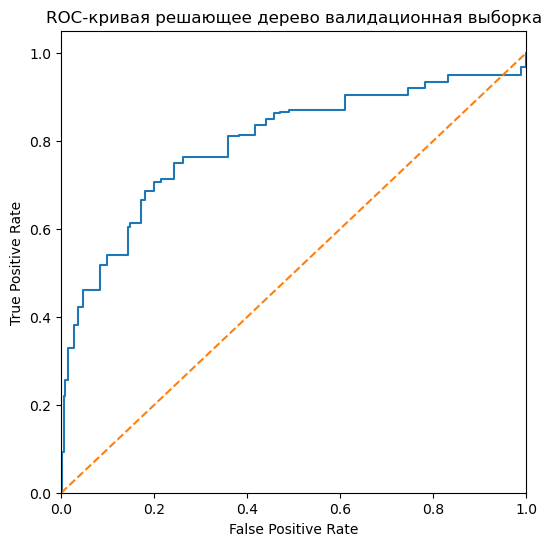

In [81]:
probabilities = decision_tree_model_weighted.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_curve_plot(fpr,tpr,variant = 'решающее дерево валидационная выборка')

In [82]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8090671240258203

При использовании балансов у модели решающего дерева, не заметили улучшений

# Прогноз с учетом upsampling 

In [83]:
features_upsampled,target_upsampled = upsample(feauters_train,target_train,4)

In [84]:
target_upsampled.value_counts(normalize = True)

exited
1    0.504919
0    0.495081
Name: proportion, dtype: float64

## Модель логистической регрессии

In [85]:
model_lin_upsamle = LogisticRegression(random_state = 1234,solver = 'liblinear')

In [86]:
model_lin_upsamle.fit(features_upsampled,target_upsampled)

LogisticRegression(random_state=1234, solver='liblinear')

In [87]:
predictions = model_lin_upsamle.predict(feauters_valid)
probabilities = model_lin_upsamle.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]

In [88]:
f1 = f1_score(target_valid,predictions)
print(f'F1 мера равна {f1}')

F1 мера равна 0.4771126760563381


In [89]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

<Figure size 640x480 with 0 Axes>

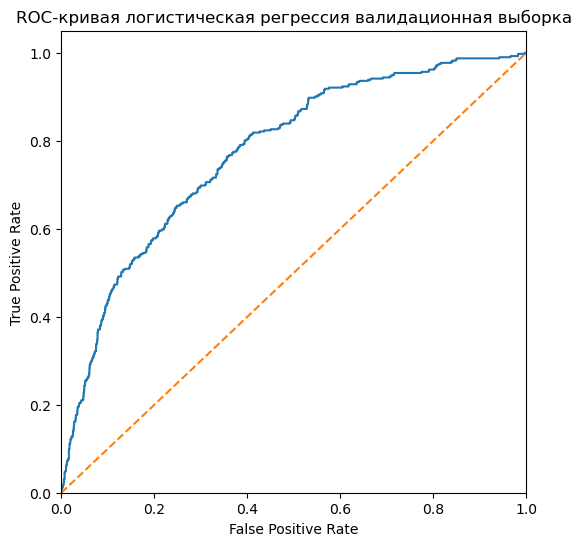

In [90]:
roc_curve_plot(fpr,tpr,variant = 'логистическая регрессия валидационная выборка')

In [91]:
roc_auc_score(target_valid, probabilities_one_valid)

0.7725692595518495

При использовании upsample модель улучшает прогнозную способность и показывает метрики f1 и площадь под roc_auc даже выше, чем при использовании баланса классов в модели.

## Случайный лес

In [92]:
random_model_upsample,df_random_forest = random_forest_learning(features_upsampled,target_upsampled, feauters_valid,target_valid,max_depth =20)

  0%|          | 0/19 [00:00<?, ?it/s]

In [93]:
random_model_upsample

RandomForestClassifier(max_depth=19, n_estimators=51, random_state=1234)

In [94]:
df_random_forest.sort_values(by = 'f1', ascending = False)

,максимальная глубина,f1,количество деревьев
0,19,0.607387,51.0
0,12,0.604423,71.0
0,19,0.604138,71.0
0,19,0.604138,61.0
0,10,0.603645,61.0
...,...,...,...
0,5,0.454829,1.0
0,4,0.408676,1.0
0,3,0.403734,1.0
0,2,0.343171,1.0


In [95]:
df_random_forest.f1.max()

0.6073871409028727

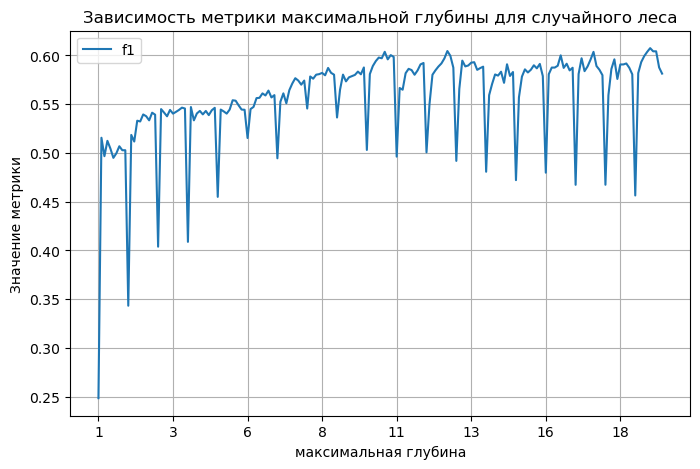

In [96]:
df_random_forest.plot(x='максимальная глубина', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики максимальной глубины для случайного леса');

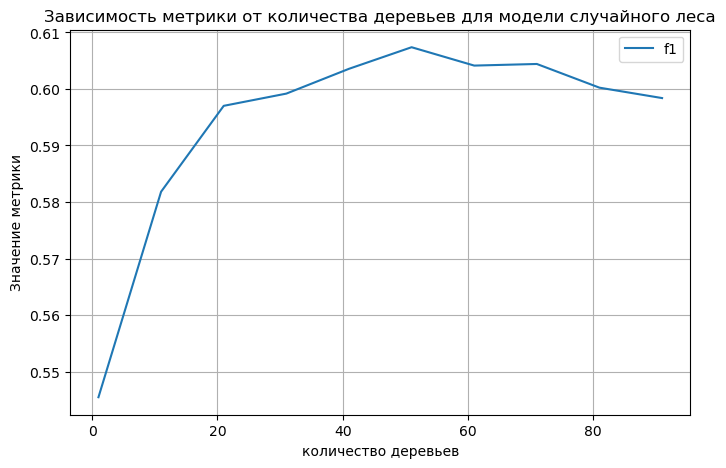

In [97]:
df_random_forest[['f1','количество деревьев']].drop_duplicates().query('f1>0').\
                        groupby('количество деревьев').agg({'f1':'max'}).reset_index().plot(x='количество деревьев', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики от количества деревьев для модели случайного леса');

<Figure size 640x480 with 0 Axes>

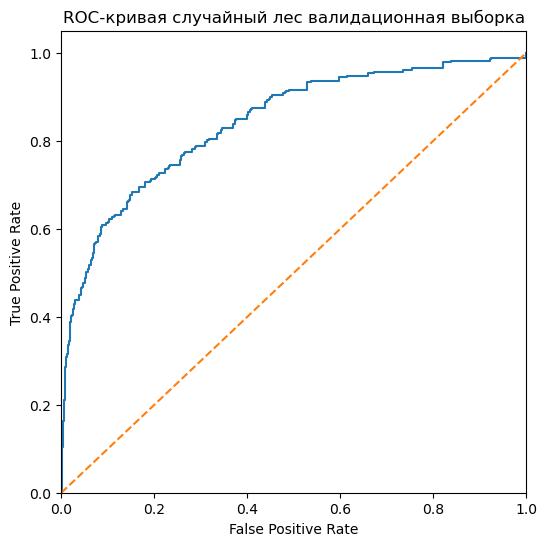

In [98]:
probabilities = random_model_upsample.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_curve_plot(fpr,tpr,variant = 'случайный лес валидационная выборка')

In [99]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8433428333908212

Наилучшие показатели метрики f1 и roc_auc_score достигаются при методе upsample у случайного леса с максимальной глубиной 19 и количеством деревьев 51. Сомневаюсь, что будет что-то лучше, но проверить необходимо. 

## Решающее дерево

In [106]:
decision_tree_model_upsample,df_decision_tree = decision_tree_learning(features_upsampled,target_upsampled, \
                                                                       feauters_valid,target_valid,max_depth =20)

  0%|          | 0/19 [00:00<?, ?it/s]

In [107]:
decision_tree_model_upsample

DecisionTreeClassifier(max_depth=6, random_state=1234)

In [108]:
df_decision_tree.f1.max()

0.5587044534412956

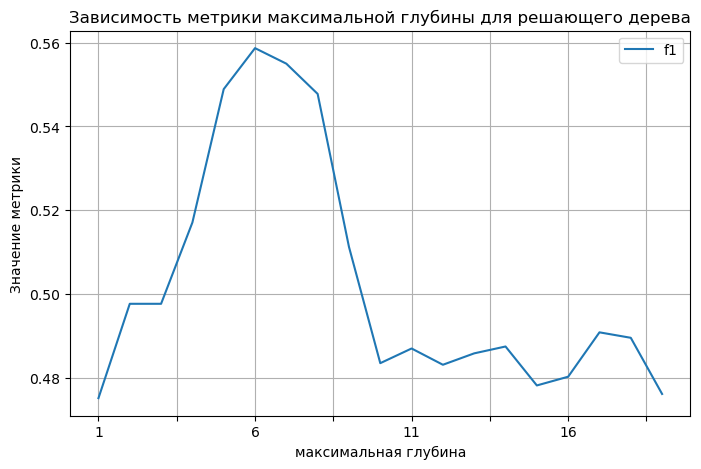

In [109]:
df_decision_tree.plot(x='максимальная глубина', y='f1', grid=True, figsize=(8,5),
    ylabel = 'Значение метрики', 
    title  = 'Зависимость метрики максимальной глубины для решающего дерева');

<Figure size 640x480 with 0 Axes>

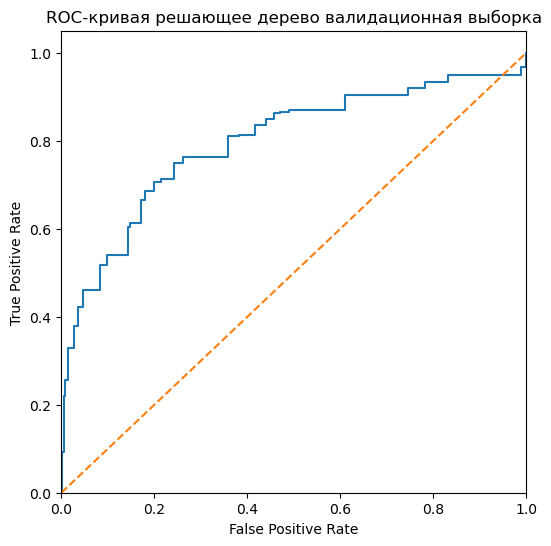

In [110]:
probabilities = decision_tree_model_upsample.predict_proba(feauters_valid)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_curve_plot(fpr,tpr,variant = 'решающее дерево валидационная выборка')

In [111]:
roc_auc_score(target_valid, probabilities_one_valid)

0.809054407830633

Результаты аналогичны decision_tree_model_weighted с применением class_weight = 'balanced'.

# Тестирование модели

Протестируем две наиболее сильные модели. Посмотрим на время их отработки 

## Случайный лес с upsample классов

In [113]:
random_model_upsample

RandomForestClassifier(max_depth=19, n_estimators=51, random_state=1234)

In [115]:
%%time

predictions = random_model_upsample.predict(feauters_test)

CPU times: user 21 ms, sys: 18.2 ms, total: 39.2 ms
Wall time: 46.6 ms


In [117]:
probabilities = random_model_upsample.predict_proba(feauters_test)
probabilities_one_valid = probabilities[:,1]

In [123]:
print(f'''
Метрика f1 для случайного леса на тестовой выборке: {round(f1_score(target_test,predictions),3)}
Метрика Accuracy для случайного леса на тестовой выборке:{accuracy_score(target_test,predictions)} ''')


Метрика f1 для случайного леса на тестовой выборке: 0.599
Метрика Accuracy для случайного леса на тестовой выборке:0.843 


## Случайный лес с balanced классов

In [124]:
random_model_weighted

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=31,
                       random_state=1234)

In [125]:
%%time

predictions = random_model_weighted.predict(feauters_test)

CPU times: user 17.5 ms, sys: 9.09 ms, total: 26.6 ms
Wall time: 59.2 ms


In [126]:
probabilities = random_model_weighted.predict_proba(feauters_test)
probabilities_one_valid = probabilities[:,1]

In [127]:
print(f'''
Метрика f1 для случайного леса на тестовой выборке: {round(f1_score(target_test,predictions),3)}
Метрика Accuracy для случайного леса на тестовой выборке:{accuracy_score(target_test,predictions)} ''')


Метрика f1 для случайного леса на тестовой выборке: 0.617
Метрика Accuracy для случайного леса на тестовой выборке:0.8505 


__Вывод:__ модель RandomForestClassifier с гиперпараметром class_weight='balanced', который учитывает дисбаланс классов показывает наилучший результат метрики f1 - 0.62, а так же лучший Accuracy - 0.8505. При этом работает медленнее, чем модель RandomForestClassifier обученная на upsampling данных. 

